In [ ]:
import numpy as np
from scipy.integrate import quad

# Define sigmoid function
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - amount

# Integration to calculate total intake
def calculate_total_intake(start, end, amount):
    total_intake, _ = quad(lambda t: intake(start, end, amount, t), start, end)
    return total_intake

# Example intake_dates
start = 1
end = 3
amount = 12

# Calculate total intake
total_intake = calculate_total_intake(start, end, amount)
total_intake


22.336446771602898

<ipython-input-37-45bcf5b5e527>:7: RuntimeWarning: overflow encountered in exp
  exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)


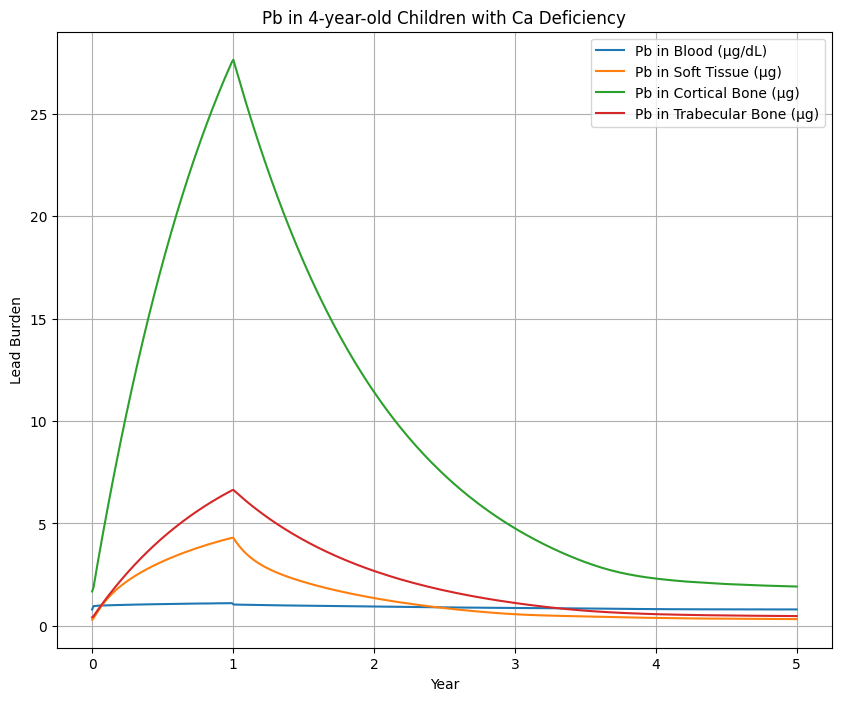

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sigmoid function for intake
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - (amount)

# Random intake function
def intake_random(intake_dates, t):
    total_intake = 0.0
    for tup in intake_dates:
        start = tup[0]
        end = tup[1]
        amount = tup[2]
        total_intake += intake(start, end, amount, t)
    return total_intake

# Parameters
T_half_b = 30 / np.log(2)  # blood half-life in days
T_half_s = 30 / np.log(2)  # soft tissue half-life in days
T_half_c = 15 * 365 / np.log(2)  # cortical bone half-life in days
T_half_t = 3 * 365 / np.log(2)  # trabecular bone half-life in days
f_cortical = 0.8
f_trabecular = 0.2
k_bone_blood = 0.01

# Calcium absorption modifier
def f_GI_C(C, RDA=1000):
    return (RDA/C)**2

# Age-dependent GI absorption rate
def f_abs(A):
    return 0.79 * (np.exp(-0.12 * A) / (np.exp(-0.12 * A) + 1)) + 0.05

# Age-dependent Pb burden in bones
def f_bone(A):
    return -0.3 * (np.exp(-0.006 * (A**2)) / (np.exp(-0.006 * (A**2)) + 1)) + 0.94

# Pb burden in soft tissues
def f_soft(A):
    return 1 - f_bone(A)

# Initial conditions
P_b0 = 0.8
P_bs0 = 0.3  # Initial soft tissue burden
P_bc0 = 1.68  # Initial cortical bone burden
P_bt0 = 0.42  # Initial trabecular bone burden
y0 = [P_b0, P_bs0, P_bc0, P_bt0]

# Differential equations
def pb_dynamics(t, y, intake_dates, C):
    P_b, P_bs, P_bc, P_bt = y
    A = t / 365 + 2
    intake_rate = intake_random(intake_dates, t)
    GI_absorption = f_abs(A) * intake_rate * f_GI_C(C)

    # Blood
    dP_b_dt = GI_absorption + k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) + k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (f_bone(A) + f_soft(A)) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_b / T_half_b) * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38)
    # Soft tissue
    dP_bs_dt = f_soft(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_bs / T_half_s) * sigmoid(1+0.1, 0, -6, -0.1, P_bs/P_bs0 - 1.38)
    # Cortical bone
    dP_bc_dt = f_cortical * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) - (P_bc / T_half_c) * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38)
    # Trabecular bone
    dP_bt_dt = f_trabecular * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (P_bt / T_half_t) * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38)

    return [dP_b_dt, dP_bs_dt, dP_bc_dt, dP_bt_dt]

# Intake schedule: (start, end, amount) in days
intake_dates = [(1, 365, 0.3)]

# Calcium intake
C = 800  # mg/day (below RDA)

# Time range for simulation in days
t_span = (0, 365*5)  # simulate from age 0 to 20 years
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol = solve_ivp(pb_dynamics, t_span, y0, args=(intake_dates, C), t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(sol.t / 365, sol.y[0], label="Pb in Blood (µg/dL)")
plt.plot(sol.t / 365, sol.y[1], label="Pb in Soft Tissue (µg)")
plt.plot(sol.t / 365, sol.y[2], label="Pb in Cortical Bone (µg)")
plt.plot(sol.t / 365, sol.y[3], label="Pb in Trabecular Bone (µg)")
plt.xlabel("Year")
plt.ylabel("Lead Burden")
plt.title("Pb in 4-year-old Children with Ca Deficiency")
plt.legend()
plt.grid()
#plt.ylim([0, 2.5])
plt.savefig("pb_children_longterm_ca_def.pdf", format="pdf")
plt.show()

<ipython-input-38-3cc7f83b76e2>:7: RuntimeWarning: overflow encountered in exp
  exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)


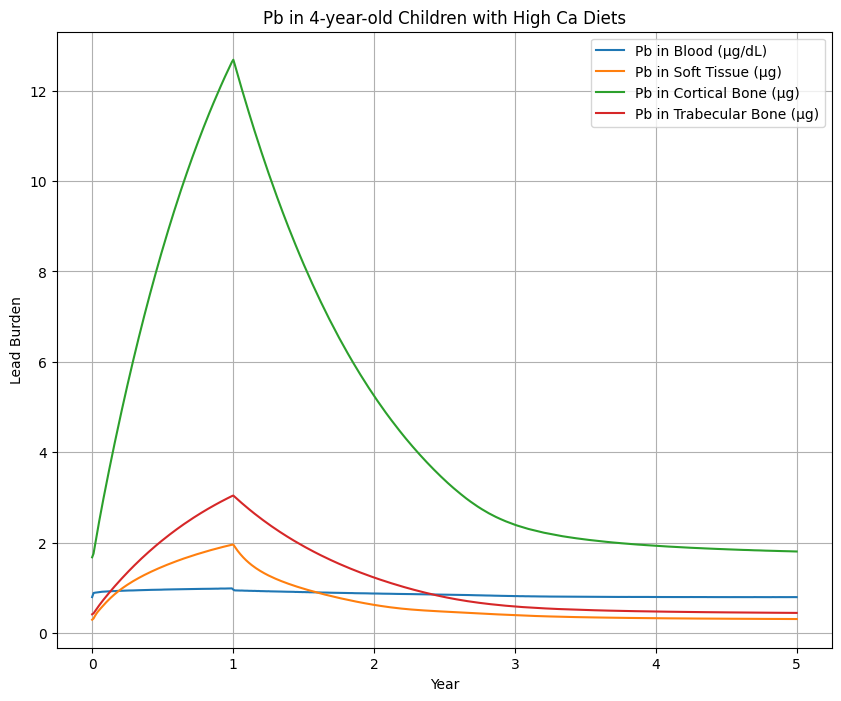

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sigmoid function for intake
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - (amount)

# Random intake function
def intake_random(intake_dates, t):
    total_intake = 0.0
    for tup in intake_dates:
        start = tup[0]
        end = tup[1]
        amount = tup[2]
        total_intake += intake(start, end, amount, t)
    return total_intake

# Parameters
T_half_b = 30 / np.log(2)  # blood half-life in days
T_half_s = 30 / np.log(2)  # soft tissue half-life in days
T_half_c = 15 * 365 / np.log(2)  # cortical bone half-life in days
T_half_t = 3 * 365 / np.log(2)  # trabecular bone half-life in days
f_cortical = 0.8
f_trabecular = 0.2
k_bone_blood = 0.01

# Calcium absorption modifier
def f_GI_C(C, RDA=1000):
    return (RDA/C)**2

# Age-dependent GI absorption rate
def f_abs(A):
    return 0.79 * (np.exp(-0.12 * A) / (np.exp(-0.12 * A) + 1)) + 0.05

# Age-dependent Pb burden in bones
def f_bone(A):
    return -0.3 * (np.exp(-0.006 * (A**2)) / (np.exp(-0.006 * (A**2)) + 1)) + 0.94

# Pb burden in soft tissues
def f_soft(A):
    return 1 - f_bone(A)

# Initial conditions
P_b0 = 0.8
P_bs0 = 0.3  # Initial soft tissue burden
P_bc0 = 1.68  # Initial cortical bone burden
P_bt0 = 0.42  # Initial trabecular bone burden
y0 = [P_b0, P_bs0, P_bc0, P_bt0]

# Differential equations
def pb_dynamics(t, y, intake_dates, C):
    P_b, P_bs, P_bc, P_bt = y
    A = t / 365 + 2
    intake_rate = intake_random(intake_dates, t)
    GI_absorption = f_abs(A) * intake_rate * f_GI_C(C)

    # Blood
    dP_b_dt = GI_absorption + k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) + k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (f_bone(A) + f_soft(A)) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_b / T_half_b) * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38)
    # Soft tissue
    dP_bs_dt = f_soft(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_bs / T_half_s) * sigmoid(1+0.1, 0, -6, -0.1, P_bs/P_bs0 - 1.38)
    # Cortical bone
    dP_bc_dt = f_cortical * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) - (P_bc / T_half_c) * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38)
    # Trabecular bone
    dP_bt_dt = f_trabecular * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (P_bt / T_half_t) * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38)

    return [dP_b_dt, dP_bs_dt, dP_bc_dt, dP_bt_dt]

# Intake schedule: (start, end, amount) in days
intake_dates = [(1, 365, 0.3)]

# Calcium intake
C = 1200  # mg/day (below RDA)

# Time range for simulation in days
t_span = (0, 365*5)  # simulate from age 0 to 20 years
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol = solve_ivp(pb_dynamics, t_span, y0, args=(intake_dates, C), t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(sol.t / 365, sol.y[0], label="Pb in Blood (µg/dL)")
plt.plot(sol.t / 365, sol.y[1], label="Pb in Soft Tissue (µg)")
plt.plot(sol.t / 365, sol.y[2], label="Pb in Cortical Bone (µg)")
plt.plot(sol.t / 365, sol.y[3], label="Pb in Trabecular Bone (µg)")
plt.xlabel("Year")
plt.ylabel("Lead Burden")
plt.title("Pb in 4-year-old Children with High Ca Diets")
plt.legend()
plt.grid()
#plt.ylim([0, 2.5])
plt.savefig("pb_children_longterm_ca_high.pdf", format="pdf")
plt.show()

<ipython-input-39-ba33e2fb3f84>:7: RuntimeWarning: overflow encountered in exp
  exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)


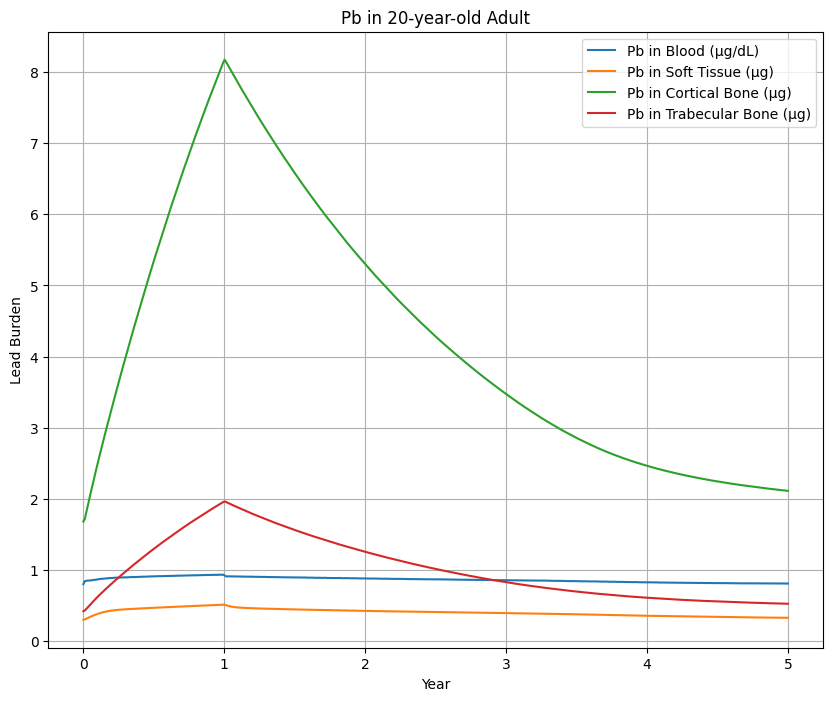

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sigmoid function for intake
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - (amount)

# Random intake function
def intake_random(intake_dates, t):
    total_intake = 0.0
    for tup in intake_dates:
        start = tup[0]
        end = tup[1]
        amount = tup[2]
        total_intake += intake(start, end, amount, t)
    return total_intake

# Parameters
T_half_b = 30 / np.log(2)  # blood half-life in days
T_half_s = 30 / np.log(2)  # soft tissue half-life in days
T_half_c = 15 * 365 / np.log(2)  # cortical bone half-life in days
T_half_t = 3 * 365 / np.log(2)  # trabecular bone half-life in days
f_cortical = 0.8
f_trabecular = 0.2
k_bone_blood = 0.01

# Calcium absorption modifier
def f_GI_C(C, RDA=1000):
    return (RDA/C)**2

# Age-dependent GI absorption rate
def f_abs(A):
    return 0.79 * (np.exp(-0.12 * A) / (np.exp(-0.12 * A) + 1)) + 0.05

# Age-dependent Pb burden in bones
def f_bone(A):
    return -0.3 * (np.exp(-0.006 * (A**2)) / (np.exp(-0.006 * (A**2)) + 1)) + 0.94

# Pb burden in soft tissues
def f_soft(A):
    return 1 - f_bone(A)

# Initial conditions
P_b0 = 0.8
P_bs0 = 0.3  # Initial soft tissue burden
P_bc0 = 1.68  # Initial cortical bone burden
P_bt0 = 0.42  # Initial trabecular bone burden
y0 = [P_b0, P_bs0, P_bc0, P_bt0]

# Differential equations
def pb_dynamics(t, y, intake_dates, C):
    P_b, P_bs, P_bc, P_bt = y
    A = t / 365 + 20
    intake_rate = intake_random(intake_dates, t)
    GI_absorption = f_abs(A) * intake_rate * f_GI_C(C)

    # Blood
    dP_b_dt = GI_absorption + k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) + k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (f_bone(A) + f_soft(A)) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_b / T_half_b) * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38)
    # Soft tissue
    dP_bs_dt = f_soft(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_bs / T_half_s) * sigmoid(1+0.1, 0, -6, -0.1, P_bs/P_bs0 - 1.38)
    # Cortical bone
    dP_bc_dt = f_cortical * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) - (P_bc / T_half_c) * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38)
    # Trabecular bone
    dP_bt_dt = f_trabecular * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (P_bt / T_half_t) * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38)

    return [dP_b_dt, dP_bs_dt, dP_bc_dt, dP_bt_dt]

# Intake schedule: (start, end, amount) in days
intake_dates = [(1, 365, 0.3)]

# Calcium intake
C = 1000  # mg/day (below RDA)

# Time range for simulation in days
t_span = (0, 365*5)  # simulate from age 0 to 20 years
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol = solve_ivp(pb_dynamics, t_span, y0, args=(intake_dates, C), t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(sol.t / 365, sol.y[0], label="Pb in Blood (µg/dL)")
plt.plot(sol.t / 365, sol.y[1], label="Pb in Soft Tissue (µg)")
plt.plot(sol.t / 365, sol.y[2], label="Pb in Cortical Bone (µg)")
plt.plot(sol.t / 365, sol.y[3], label="Pb in Trabecular Bone (µg)")
plt.xlabel("Year")
plt.ylabel("Lead Burden")
plt.title("Pb in 20-year-old Adult")
plt.legend()
plt.grid()
#plt.ylim([0, 2.5])
plt.savefig("pb_adult_longterm.pdf", format="pdf")
plt.show()

<ipython-input-1-62c2af12cc99>:7: RuntimeWarning: overflow encountered in exp
  exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)


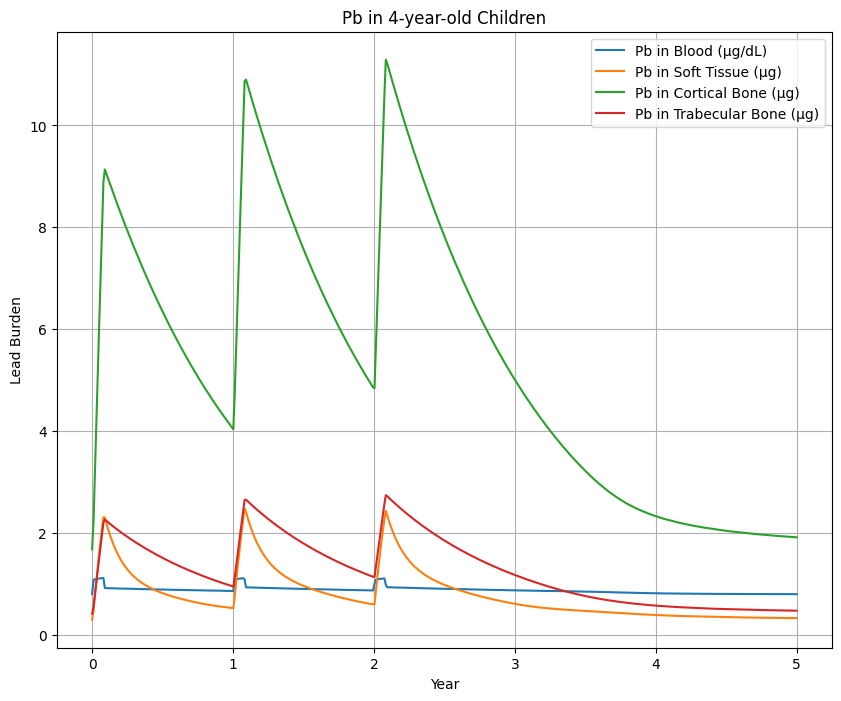

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sigmoid function for intake
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - (amount)

# Random intake function
def intake_random(intake_dates, t):
    total_intake = 0.0
    for tup in intake_dates:
        start = tup[0]
        end = tup[1]
        amount = tup[2]
        total_intake += intake(start, end, amount, t)
    return total_intake

# Parameters
T_half_b = 30 / np.log(2)  # blood half-life in days
T_half_s = 30 / np.log(2)  # soft tissue half-life in days
T_half_c = 15 * 365 / np.log(2)  # cortical bone half-life in days
T_half_t = 3 * 365 / np.log(2)  # trabecular bone half-life in days
f_cortical = 0.8
f_trabecular = 0.2
k_bone_blood = 0.01

# Calcium absorption modifier
def f_GI_C(C, RDA=1000):
    return (RDA/C)**2

# Age-dependent GI absorption rate
def f_abs(A):
    return 0.79 * (np.exp(-0.12 * A) / (np.exp(-0.12 * A) + 1)) + 0.05

# Age-dependent Pb burden in bones
def f_bone(A):
    return -0.3 * (np.exp(-0.006 * (A**2)) / (np.exp(-0.006 * (A**2)) + 1)) + 0.94

# Pb burden in soft tissues
def f_soft(A):
    return 1 - f_bone(A)

# Initial conditions
P_b0 = 0.8
P_bs0 = 0.3  # Initial soft tissue burden
P_bc0 = 1.68  # Initial cortical bone burden
P_bt0 = 0.42  # Initial trabecular bone burden
y0 = [P_b0, P_bs0, P_bc0, P_bt0]

# Differential equations
def pb_dynamics(t, y, intake_dates, C):
    P_b, P_bs, P_bc, P_bt = y
    A = t / 365
    intake_rate = intake_random(intake_dates, t)
    GI_absorption = f_abs(A) * intake_rate * f_GI_C(C)

    # Blood
    dP_b_dt = GI_absorption + k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) + k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (f_bone(A) + f_soft(A)) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_b / T_half_b) * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38)
    # Soft tissue
    dP_bs_dt = f_soft(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_bs / T_half_s) * sigmoid(1+0.1, 0, -6, -0.1, P_bs/P_bs0 - 1.38)
    # Cortical bone
    dP_bc_dt = f_cortical * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) - (P_bc / T_half_c) * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38)
    # Trabecular bone
    dP_bt_dt = f_trabecular * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (P_bt / T_half_t) * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38)

    return [dP_b_dt, dP_bs_dt, dP_bc_dt, dP_bt_dt]

# Intake schedule: (start, end, amount) in days
intake_dates = [(1, 30, 1 ), (1+365, 30+365, 1), (1+365*2, 30+365*2, 1)]

# Calcium intake
C = 1000  # mg/day (below RDA)

# Time range for simulation in days
t_span = (0, 365*5)  # simulate from age 0 to 20 years
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol = solve_ivp(pb_dynamics, t_span, y0, args=(intake_dates, C), t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(sol.t / 365, sol.y[0], label="Pb in Blood (µg/dL)")
plt.plot(sol.t / 365, sol.y[1], label="Pb in Soft Tissue (µg)")
plt.plot(sol.t / 365, sol.y[2], label="Pb in Cortical Bone (µg)")
plt.plot(sol.t / 365, sol.y[3], label="Pb in Trabecular Bone (µg)")
plt.xlabel("Year")
plt.ylabel("Lead Burden")
plt.title("Pb in 4-year-old Children")
plt.legend()
plt.grid()
#plt.ylim([0, 2.5])
plt.savefig("pb_children_holiday.pdf", format="pdf")
plt.show()

<ipython-input-2-5d191a31337c>:7: RuntimeWarning: overflow encountered in exp
  exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)


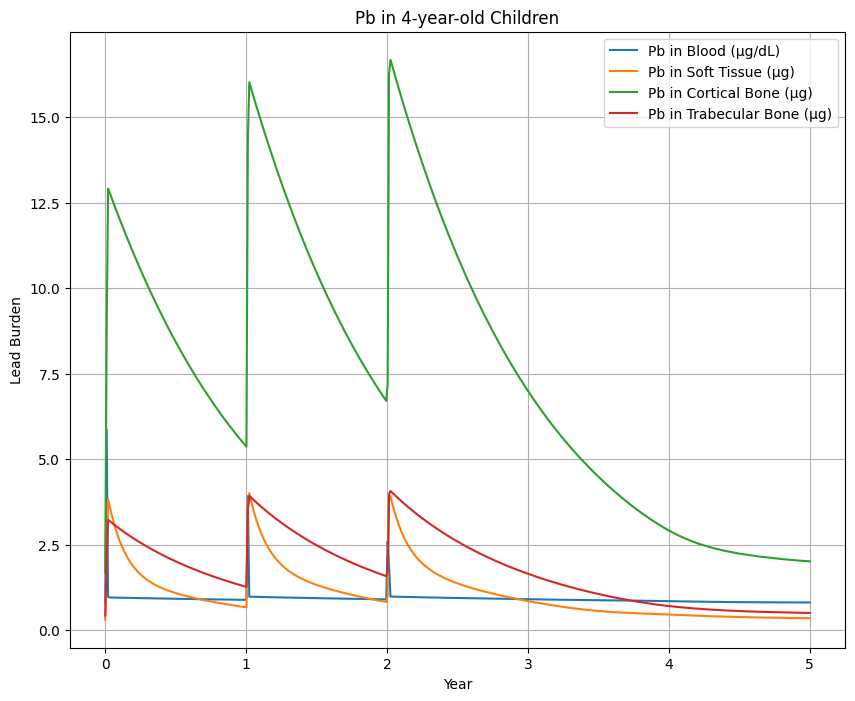

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sigmoid function for intake
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - (amount)

# Random intake function
def intake_random(intake_dates, t):
    total_intake = 0.0
    for tup in intake_dates:
        start = tup[0]
        end = tup[1]
        amount = tup[2]
        total_intake += intake(start, end, amount, t)
    return total_intake

# Parameters
T_half_b = 30 / np.log(2)  # blood half-life in days
T_half_s = 30 / np.log(2)  # soft tissue half-life in days
T_half_c = 15 * 365 / np.log(2)  # cortical bone half-life in days
T_half_t = 3 * 365 / np.log(2)  # trabecular bone half-life in days
f_cortical = 0.8
f_trabecular = 0.2
k_bone_blood = 0.01

# Calcium absorption modifier
def f_GI_C(C, RDA=1000):
    return (RDA/C)**2

# Age-dependent GI absorption rate
def f_abs(A):
    return 0.79 * (np.exp(-0.12 * A) / (np.exp(-0.12 * A) + 1)) + 0.05

# Age-dependent Pb burden in bones
def f_bone(A):
    return -0.3 * (np.exp(-0.006 * (A**2)) / (np.exp(-0.006 * (A**2)) + 1)) + 0.94

# Pb burden in soft tissues
def f_soft(A):
    return 1 - f_bone(A)

# Initial conditions
P_b0 = 0.8
P_bs0 = 0.3  # Initial soft tissue burden
P_bc0 = 1.68  # Initial cortical bone burden
P_bt0 = 0.42  # Initial trabecular bone burden
y0 = [P_b0, P_bs0, P_bc0, P_bt0]

# Differential equations
def pb_dynamics(t, y, intake_dates, C):
    P_b, P_bs, P_bc, P_bt = y
    A = t / 365
    intake_rate = intake_random(intake_dates, t)
    GI_absorption = f_abs(A) * intake_rate * f_GI_C(C)

    # Blood
    dP_b_dt = GI_absorption + k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) + k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (f_bone(A) + f_soft(A)) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_b / T_half_b) * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38)
    # Soft tissue
    dP_bs_dt = f_soft(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_bs / T_half_s) * sigmoid(1+0.1, 0, -6, -0.1, P_bs/P_bs0 - 1.38)
    # Cortical bone
    dP_bc_dt = f_cortical * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) - (P_bc / T_half_c) * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38)
    # Trabecular bone
    dP_bt_dt = f_trabecular * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (P_bt / T_half_t) * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38)

    return [dP_b_dt, dP_bs_dt, dP_bc_dt, dP_bt_dt]

# Intake schedule: (start, end, amount) in days
intake_dates = [(1, 4, 14), (1+365, 4+365, 14), (1+365*2, 4+365*2, 14)]

# Calcium intake
C = 1000  # mg/day (below RDA)

# Time range for simulation in days
t_span = (0, 365*5)  # simulate from age 0 to 20 years
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol = solve_ivp(pb_dynamics, t_span, y0, args=(intake_dates, C), t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(sol.t / 365, sol.y[0], label="Pb in Blood (µg/dL)")
plt.plot(sol.t / 365, sol.y[1], label="Pb in Soft Tissue (µg)")
plt.plot(sol.t / 365, sol.y[2], label="Pb in Cortical Bone (µg)")
plt.plot(sol.t / 365, sol.y[3], label="Pb in Trabecular Bone (µg)")
plt.xlabel("Year")
plt.ylabel("Lead Burden")
plt.title("Pb in 4-year-old Children")
plt.legend()
plt.grid()
#plt.ylim([0, 2.5])
plt.savefig("pb_children_binge.pdf", format="pdf")
plt.show()

<ipython-input-50-20b0318f6a70>:7: RuntimeWarning: overflow encountered in exp
  exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)


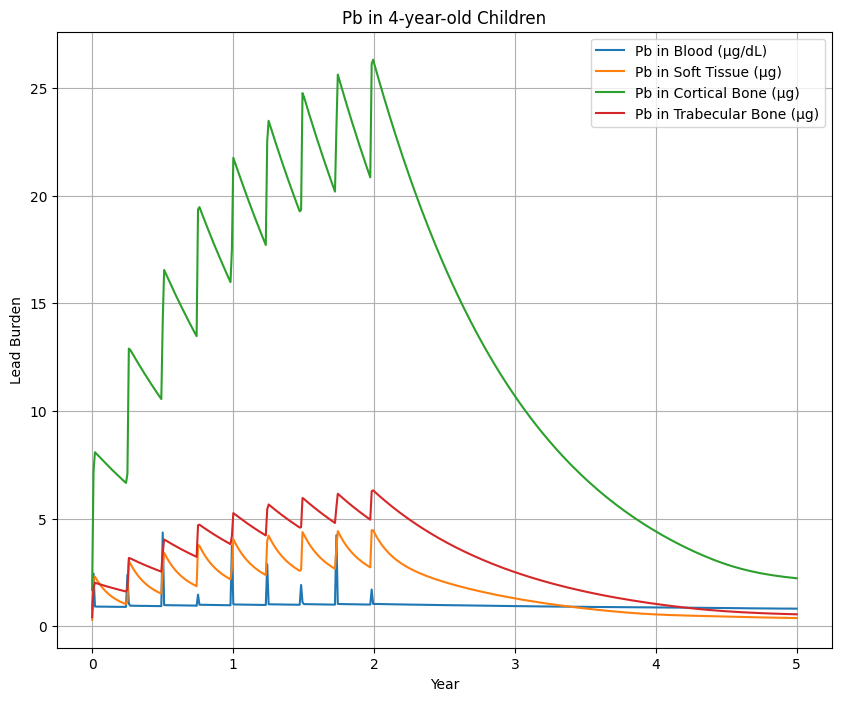

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sigmoid function for intake
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - (amount)

# Random intake function
def intake_random(intake_dates, t):
    total_intake = 0.0
    for tup in intake_dates:
        start = tup[0]
        end = tup[1]
        amount = tup[2]
        total_intake += intake(start, end, amount, t)
    return total_intake

# Parameters
T_half_b = 30 / np.log(2)  # blood half-life in days
T_half_s = 30 / np.log(2)  # soft tissue half-life in days
T_half_c = 15 * 365 / np.log(2)  # cortical bone half-life in days
T_half_t = 3 * 365 / np.log(2)  # trabecular bone half-life in days
f_cortical = 0.8
f_trabecular = 0.2
k_bone_blood = 0.01

# Calcium absorption modifier
def f_GI_C(C, RDA=1000):
    return (RDA/C)**2

# Age-dependent GI absorption rate
def f_abs(A):
    return 0.79 * (np.exp(-0.12 * A) / (np.exp(-0.12 * A) + 1)) + 0.05

# Age-dependent Pb burden in bones
def f_bone(A):
    return -0.3 * (np.exp(-0.006 * (A**2)) / (np.exp(-0.006 * (A**2)) + 1)) + 0.94

# Pb burden in soft tissues
def f_soft(A):
    return 1 - f_bone(A)

# Initial conditions
P_b0 = 0.8
P_bs0 = 0.3  # Initial soft tissue burden
P_bc0 = 1.68  # Initial cortical bone burden
P_bt0 = 0.42  # Initial trabecular bone burden
y0 = [P_b0, P_bs0, P_bc0, P_bt0]

# Differential equations
def pb_dynamics(t, y, intake_dates, C):
    P_b, P_bs, P_bc, P_bt = y
    A = t / 365
    intake_rate = intake_random(intake_dates, t)
    GI_absorption = f_abs(A) * intake_rate * f_GI_C(C)

    # Blood
    dP_b_dt = GI_absorption + k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) + k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (f_bone(A) + f_soft(A)) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_b / T_half_b) * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38)
    # Soft tissue
    dP_bs_dt = f_soft(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_bs / T_half_s) * sigmoid(1+0.1, 0, -6, -0.1, P_bs/P_bs0 - 1.38)
    # Cortical bone
    dP_bc_dt = f_cortical * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) - (P_bc / T_half_c) * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38)
    # Trabecular bone
    dP_bt_dt = f_trabecular * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (P_bt / T_half_t) * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38)

    return [dP_b_dt, dP_bs_dt, dP_bc_dt, dP_bt_dt]

# Intake schedule: (start, end, amount) in days
intake_dates = [(1, 3, 12), (1+30*3, 3+30*3, 12), (1+30*6, 3+30*6, 12), (1+30*9, 3+30*9, 12), (1+30*12, 3+30*12, 12), (1+30*15, 3+30*15, 12), (1+30*18, 3+30*18, 12), (1+30*21, 3+30*21, 12), (1+30*24, 3+30*24, 12)]

# Calcium intake
C = 1000  # mg/day (below RDA)

# Time range for simulation in days
t_span = (0, 365*5)  # simulate from age 0 to 20 years
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol = solve_ivp(pb_dynamics, t_span, y0, args=(intake_dates, C), t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(sol.t / 365, sol.y[0], label="Pb in Blood (µg/dL)")
plt.plot(sol.t / 365, sol.y[1], label="Pb in Soft Tissue (µg)")
plt.plot(sol.t / 365, sol.y[2], label="Pb in Cortical Bone (µg)")
plt.plot(sol.t / 365, sol.y[3], label="Pb in Trabecular Bone (µg)")
plt.xlabel("Year")
plt.ylabel("Lead Burden")
plt.title("Pb in 4-year-old Children")
plt.legend()
plt.grid()
#plt.ylim([0, 2.5])
plt.savefig("pb_children_holiday_near.pdf", format="pdf")
plt.show()

<ipython-input-51-fce47c1ca2e7>:7: RuntimeWarning: overflow encountered in exp
  exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)


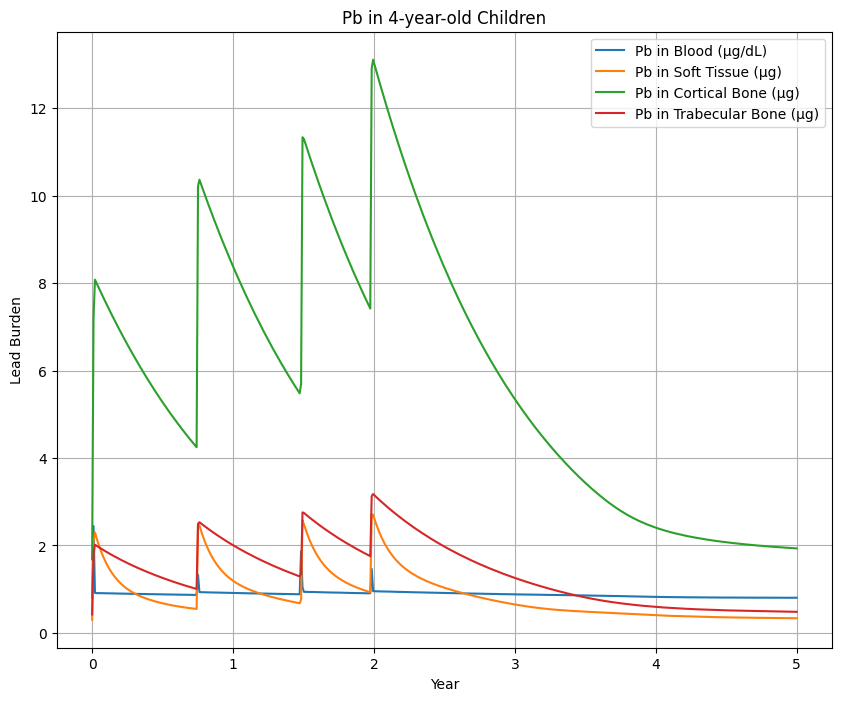

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sigmoid function for intake
def sigmoid(a, b, c, k, t):
    exp_component = np.clip(np.exp(-(c * (t - b))), 1e-10, 1e10)
    return a * exp_component / (exp_component + 1) + k

# Intake function
def intake(start, end, amount, t):
    f = sigmoid(amount, start, -10, 0, t)
    g = sigmoid(amount, end, 10, 0, t)
    return f + g - (amount)

# Random intake function
def intake_random(intake_dates, t):
    total_intake = 0.0
    for tup in intake_dates:
        start = tup[0]
        end = tup[1]
        amount = tup[2]
        total_intake += intake(start, end, amount, t)
    return total_intake

# Parameters
T_half_b = 30 / np.log(2)  # blood half-life in days
T_half_s = 30 / np.log(2)  # soft tissue half-life in days
T_half_c = 15 * 365 / np.log(2)  # cortical bone half-life in days
T_half_t = 3 * 365 / np.log(2)  # trabecular bone half-life in days
f_cortical = 0.8
f_trabecular = 0.2
k_bone_blood = 0.01

# Calcium absorption modifier
def f_GI_C(C, RDA=1000):
    return (RDA/C)**2

# Age-dependent GI absorption rate
def f_abs(A):
    return 0.79 * (np.exp(-0.12 * A) / (np.exp(-0.12 * A) + 1)) + 0.05

# Age-dependent Pb burden in bones
def f_bone(A):
    return -0.3 * (np.exp(-0.006 * (A**2)) / (np.exp(-0.006 * (A**2)) + 1)) + 0.94

# Pb burden in soft tissues
def f_soft(A):
    return 1 - f_bone(A)

# Initial conditions
P_b0 = 0.8
P_bs0 = 0.3  # Initial soft tissue burden
P_bc0 = 1.68  # Initial cortical bone burden
P_bt0 = 0.42  # Initial trabecular bone burden
y0 = [P_b0, P_bs0, P_bc0, P_bt0]

# Differential equations
def pb_dynamics(t, y, intake_dates, C):
    P_b, P_bs, P_bc, P_bt = y
    A = t / 365
    intake_rate = intake_random(intake_dates, t)
    GI_absorption = f_abs(A) * intake_rate * f_GI_C(C)

    # Blood
    dP_b_dt = GI_absorption + k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) + k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (f_bone(A) + f_soft(A)) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_b / T_half_b) * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38)
    # Soft tissue
    dP_bs_dt = f_soft(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - (P_bs / T_half_s) * sigmoid(1+0.1, 0, -6, -0.1, P_bs/P_bs0 - 1.38)
    # Cortical bone
    dP_bc_dt = f_cortical * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bc * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38) - (P_bc / T_half_c) * sigmoid(1+0.1, 0, -6, -0.1, P_bc/P_bc0 - 1.38)
    # Trabecular bone
    dP_bt_dt = f_trabecular * f_bone(A) * P_b * sigmoid(1+0.1, 0, -6, -0.1, P_b/P_b0 - 1.38) - k_bone_blood * P_bt * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38) - (P_bt / T_half_t) * sigmoid(1+0.1, 0, -6, -0.1, P_bt/P_bt0 - 1.38)

    return [dP_b_dt, dP_bs_dt, dP_bc_dt, dP_bt_dt]

# Intake schedule: (start, end, amount) in days
intake_dates = [(1, 3, 12), (1+30*9, 3+30*9, 12), (1+30*18, 3+30*18, 12), (1+30*24, 3+30*24, 12)]

# Calcium intake
C = 1000  # mg/day (below RDA)

# Time range for simulation in days
t_span = (0, 365*5)  # simulate from age 0 to 20 years
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol = solve_ivp(pb_dynamics, t_span, y0, args=(intake_dates, C), t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(sol.t / 365, sol.y[0], label="Pb in Blood (µg/dL)")
plt.plot(sol.t / 365, sol.y[1], label="Pb in Soft Tissue (µg)")
plt.plot(sol.t / 365, sol.y[2], label="Pb in Cortical Bone (µg)")
plt.plot(sol.t / 365, sol.y[3], label="Pb in Trabecular Bone (µg)")
plt.xlabel("Year")
plt.ylabel("Lead Burden")
plt.title("Pb in 4-year-old Children")
plt.legend()
plt.grid()
#plt.ylim([0, 2.5])
plt.savefig("pb_children_holiday_far.pdf", format="pdf")
plt.show()